# Analyzing Open Source Baseball Data

This notebook answers baseball questions that a fan might be interested in. The questions are answered by using Pandas and the Lahman/Retrosheet data.

This notebook will explain how the answer is arrived at, but it will not teach Python, Pandas, Numpy, Matplotlib, and Seaborn per se.

## Table of Contents
[Imports and Setup](#Imports-and-Setup)  
[Load Data](#Load-the-Data)  
[Are Baseball Games Getting Longer?](#Are-Baseball-Games-Getting-Longer-?)  
[Are Games Longer due to Using More Pitchers?](#Are-Games-Longer-Due-to-Using-More-Pitchers?)  
[Are Games that Use a DH Higher Scoring?](#Are-Games-that-Use-a-DH-Higher-Scoring?)  

## Preliminaries

This notebook assumes that the Lahman and Retrosheet data sets have been downloaded and wrangled using the scripts in the `../download_scripts` directory of this repo.

## MLB Data Summary

Description of key csv files.

**Lahman**  
* Stats per Player per Year:
  * batting.csv
  * pitching.csv
  * fielding.csv
* Stats per Team per Year:
  * teams.csv -- contains team_id for both Lahman and Retrosheet
* Other
  * people.csv -- contains player_id for both Lahman and Retrosheet
  
**Retrosheet**  
* Stats per Player per Game:
  * batting.csv.gz
  * pitching.csv.gz
  * fielding.csv.gz
* Stats per Team per Game:
  * team_game.csv.gz
* Stats per Game:
  * game.csv.gz 

## Imports and Setup

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # increase the default dpi

In [4]:
import sys

# import data_helper.py from download_scripts directory
sys.path.append('../download_scripts')
import data_helper as dh

In [5]:
data_dir = Path('../data')
lahman_data = data_dir.joinpath('lahman/wrangled').resolve()
retrosheet_data = data_dir.joinpath('retrosheet/wrangled').resolve()

In [6]:
pd.set_option("display.max_columns", 50)

## Load the Data

In [7]:
# some columns of interest
usecols = ['game_id', 'game_start_dt', 'game_length_minutes', 'game_length_outs', 
           'game_length_innings', 'dh']
game = dh.from_csv_with_types(retrosheet_data / 'game.csv.gz', usecols=usecols)

In [8]:
game.head(3)

,game_id,game_start_dt,game_length_minutes,game_length_innings,game_length_outs,dh
0,BAL195504120,1955-04-12,145,9,54,False
1,BAL195504180,1955-04-18,146,9,54,False
2,BAL195504220,1955-04-22,168,9,54,False


In [9]:
usecols = (lambda col: not col.startswith('lineup'))
team_game = dh.from_csv_with_types(retrosheet_data / 'team_game.csv.gz', usecols=usecols)

In [10]:
team_game.head(3)

,game_id,at_home,team_id,start_pit_id,opponent_team_id,r,h,e,lob,finish_pit_id,team_league_id,line_tx,ab,double,triple,hr,rbi,sh,sf,hbp,bb,ibb,so,sb,cs,gidp,xi,pitcher_ct,er,ter,wp,bk,po,a,pb,dp,tp
0,BAL195504120,True,BAL,colej101,BOS,1,5,2,9,ferrd102,A,001000000,29,2,0,0,1,1,1,0,6,0,5,0,1,0,0,3,6,6,0,0,27,12,0,2,0
1,BAL195504180,True,BAL,moorr101,NYA,0,3,1,4,wilsj104,A,000000000,29,0,0,0,0,0,0,0,2,0,6,0,0,0,0,3,4,4,0,0,27,9,0,2,0
2,BAL195504220,True,BAL,wilsj104,WS1,2,8,1,11,johnd102,A,000000200,33,0,1,0,2,0,0,0,7,0,6,0,1,0,0,2,2,2,0,0,27,12,0,1,0


# Are Baseball Games Getting Longer ?

In [11]:
# analysis is easier if there is an explict year column
game['year'] = game['game_start_dt'].dt.year

In [12]:
minutes_per_game = \
    game.groupby('year', as_index=False)['game_length_minutes'].aggregate('mean')
minutes_per_game.tail()

,year,game_length_minutes
60,2015,180.804446
61,2016,184.771005
62,2017,188.736626
63,2018,184.953928
64,2019,189.989296


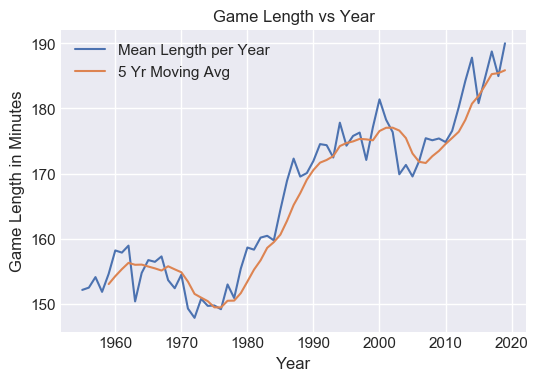

In [13]:
# plot the data and the smoothed data
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots()
ax.set_title('Game Length vs Year')
ax.set_xlabel('Year')
ax.set_ylabel('Game Length in Minutes')
ax.set_title('Game Length vs Year')

ax.plot('year', 'game_length_minutes', data = minutes_per_game, label='Mean Length per Year')
df_smoothed = minutes_per_game.set_index('year').rolling(5).mean().reset_index()
ax.plot('year', 'game_length_minutes', data=df_smoothed, label='5 Yr Moving Avg')
ax.legend();

Baseball games are taking longer to complete.

# Are Games Longer Due to Using More Pitchers?

In [14]:
team_game['year'] = team_game['game_id'].str[3:7].astype('int')

In [15]:
pitcher_ct_mean = team_game.groupby('year', as_index=False)['pitcher_ct'].mean()
pitcher_ct_mean

,year,pitcher_ct
0,1955,2.412259
1,1956,2.397490
2,1957,2.437449
3,1958,2.437754
4,1959,2.393522
...,...,...
60,2015,4.109922
61,2016,4.152801
62,2017,4.222016
63,2018,4.361374


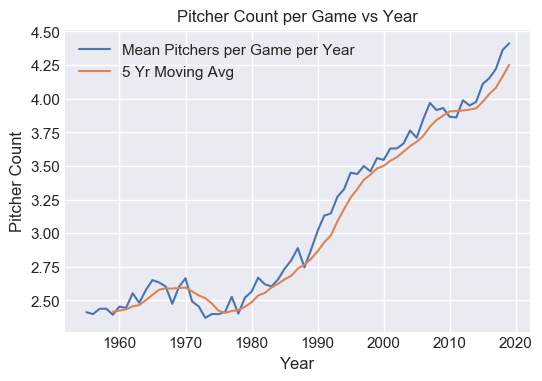

In [16]:
# plot the data and the smoothed data
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots()
ax.set_title('Pitcher Count per Game vs Year')
ax.set_xlabel('Year')
ax.set_ylabel('Pitcher Count')

ax.plot('year', 'pitcher_ct', data=pitcher_ct_mean, label='Mean Pitchers per Game per Year')
df_smoothed2 = pitcher_ct_mean.set_index('year').rolling(5).mean().reset_index()
ax.plot('year', 'pitcher_ct', data=df_smoothed2, label='5 Yr Moving Avg')
ax.legend();

The number of pitchers per game has been steadily increasing since the late 70s.

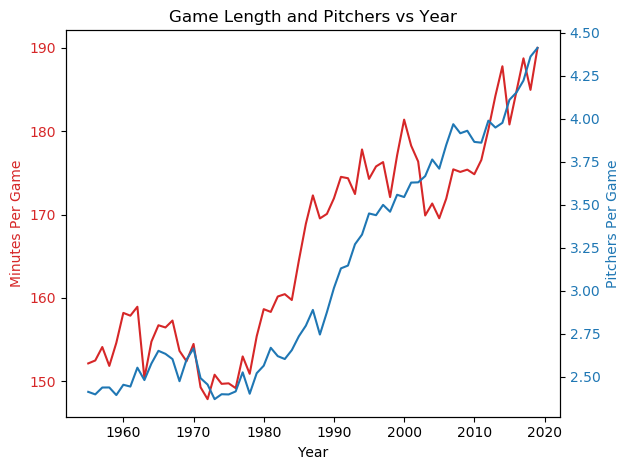

In [17]:
# show game length and pitcher count on same plot
# x = df_smoothed['year']
# y1 = df_smoothed['game_length_minutes']
# y2 = df_smoothed2['pitcher_ct']

x = minutes_per_game['year']
y1 = minutes_per_game['game_length_minutes']
y2 = pitcher_ct_mean['pitcher_ct']

plt.style.use('default')

fig, ax1 = plt.subplots()
ax1.set_title('Game Length and Pitchers vs Year')
ax1.set_xlabel('Year')

color = 'tab:red'
ax1.set_ylabel('Minutes Per Game', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pitchers Per Game', color=color)
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

It looks like both game length and pitcher count are increasing in roughly the same manner.
What's the Pearson Correlation Coefficient using the ungrouped data?

In [18]:
df = pd.merge(team_game[['game_id', 'team_id', 'pitcher_ct']], game[['game_id', 'year', 'game_length_minutes']], 
              left_on='game_id', right_on='game_id', how='inner')
df.head()

,game_id,team_id,pitcher_ct,year,game_length_minutes
0,BAL195504120,BAL,3,1955,145
1,BAL195504120,BOS,1,1955,145
2,BAL195504180,BAL,3,1955,146
3,BAL195504180,NYA,1,1955,146
4,BAL195504220,BAL,2,1955,168


In [19]:
df['pitcher_ct'].corr(df['game_length_minutes']).round(3)

0.618

In [20]:
len(df)

264596

0.618 is a significant correlation for so many games.  Using more pitchers is associated with a longer game.

In [21]:
# check the p-value (for a linear relationship)
from scipy.stats import linregress
x = linregress(df['pitcher_ct'], df['game_length_minutes'])
x.pvalue, x.rvalue

(0.0, 0.6177469195166662)

# Are Games that Use a DH Higher Scoring?

In [22]:
# find the first year that the dh was used
dh_first = game.loc[game['dh'], 'year'].min()
dh_first

1973

In [23]:
# only consider games from that year on
game_dh = game[game['year'] >= dh_first]

In [24]:
# join between game and team_game to get the scores
df = pd.merge(team_game[['game_id', 'team_id', 'r']], game_dh[['game_id', 'year', 'dh']], 
              left_on='game_id', right_on='game_id', how='inner')
df.head()

,game_id,team_id,r,year,dh
0,ATL197304060,ATL,1,1973,False
1,ATL197304060,HOU,2,1973,False
2,ATL197304081,ATL,3,1973,False
3,ATL197304081,HOU,10,1973,False
4,ATL197304082,ATL,4,1973,False


In [25]:
dh_games = df[df['dh']]
no_dh_games = df[~df['dh']]

In [26]:
dh_games['r'].mean()

4.626851267939384

In [27]:
no_dh_games['r'].mean()

4.362823898648907

In [28]:
len(dh_games), len(no_dh_games)

(104658, 104508)

In [29]:
delta = dh_games['r'].mean() - no_dh_games['r'].mean()
delta

0.2640273692904769

Given the large number of games, this looks significant.  Run the <a href="https://en.wikipedia.org/wiki/Resampling_(statistics)#Monte_Carlo_testing">Monte Carlo</a> version of the <a href="https://en.wikipedia.org/wiki/Resampling_(statistics)#Permutation_tests">Permutation Test</a> to see how likely this large of a difference is.

In [30]:
x = dh_games['r'].values
y = no_dh_games['r'].values

In [31]:
def perm_test(x, y):
    pooled = np.hstack([x, y])
    np.random.shuffle(pooled)
    x_sample = pooled[:len(x)]
    y_sample = pooled[len(x):]
    return x_sample.mean() - y_sample.mean()

In [32]:
np.random.seed(100)
N = 1000
result_array = np.empty(N)
for i in range(N):
    result_array[i] = perm_test(x,y)

In [33]:
result_array.min(), result_array.max()

(-0.03885183947546089, 0.03976518459555578)

In [34]:
(result_array >= delta).mean()

0.0

The observed difference of 0.264 is many times larger than the largest difference observed by chance in 1000 experiments.

The use of the Designated Hitter is associated with a higher score.